# ELAIS S1 Master List Creation

## Preparation of VIDEO/VISTA/VIRCAM data


The catalogue comes from `dmu0_VISTA_VIDEO-private`.

There is an old public version of the catalogue but we are using the newer private version in the hope that it will be public by the time we publish the masterlist.

Filters: Y,J,H,Ks 

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position (degrees);
- The stellarity;
- The magnitude for each band in apertude 3, which is 2 arcsec (rs548 presumes same for private catalogue).
- The “auto” magnitude is provided, we presume this is standard Sextractor units etc.

Yannick said the dates of observation for VIDEO are from 2009/11 to 2016/12. There is a paper from 2012 (Jarvis et al). So will use 2012.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
37d9c0f (Tue Jul 18 17:43:07 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

'en_GB'

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [5]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "video_ra"
DEC_COL = "video_dec"

## I - Column selection

In [6]:
imported_columns = OrderedDict({
        'ID':              'video_id', 
        'ALPHA_J2000':     'video_ra', 
        'DELTA_J2000':     'video_dec', 
        'J_CLASS_STAR':    'video_stellarity', 
        'Z_MAG_APER_3':    'm_ap_video_z', 
        'Z_MAGERR_APER_3': 'merr_ap_video_z', 
        'Z_MAG_AUTO':      'm_video_z', 
        'Z_MAGERR_AUTO':   'merr_video_z',
        'Z_FLUX_APER_3':   'f_ap_video_z', 
        'Z_FLUXERR_APER_3':'ferr_ap_video_z', 
        'Z_FLUX_AUTO':     'f_video_z', 
        'Z_FLUXERR_AUTO':  'ferr_video_z',
        'Y_MAG_APER_3':    'm_ap_video_y', 
        'Y_MAGERR_APER_3': 'merr_ap_video_y', 
        'Y_MAG_AUTO':      'm_video_y', 
        'Y_MAGERR_AUTO':   'merr_video_y',
        'Y_FLUX_APER_3':   'f_ap_video_y', 
        'Y_FLUXERR_APER_3':'ferr_ap_video_y', 
        'Y_FLUX_AUTO':     'f_video_y', 
        'Y_FLUXERR_AUTO':  'ferr_video_y',
        'J_MAG_APER_3':    'm_ap_video_j', 
        'J_MAGERR_APER_3': 'merr_ap_video_j', 
        'J_MAG_AUTO':      'm_video_j', 
        'J_MAGERR_AUTO':   'merr_video_j',
        'J_FLUX_APER_3':   'f_ap_video_j', 
        'J_FLUXERR_APER_3':'ferr_ap_video_j', 
        'J_FLUX_AUTO':     'f_video_j', 
        'J_FLUXERR_AUTO':  'ferr_video_j',
        'H_MAG_APER_3':    'm_ap_video_h', 
        'H_MAGERR_APER_3': 'merr_ap_video_h', 
        'H_MAG_AUTO':      'm_video_h', 
        'H_MAGERR_AUTO':   'merr_video_h',
        'H_FLUX_APER_3':   'f_ap_video_h', 
        'H_FLUXERR_APER_3':'ferr_ap_video_h', 
        'H_FLUX_AUTO':     'f_video_h', 
        'H_FLUXERR_AUTO':  'ferr_video_h',    
        'K_MAG_APER_3':    'm_ap_video_k', 
        'K_MAGERR_APER_3': 'merr_ap_video_k', 
        'K_MAG_AUTO':      'm_video_k', 
        'K_MAGERR_AUTO':   'merr_video_k',
        'K_FLUX_APER_3':   'f_ap_video_k', 
        'K_FLUXERR_APER_3':'ferr_ap_video_k', 
        'K_FLUX_AUTO':     'f_video_k', 
        'K_FLUXERR_AUTO':  'ferr_video_k'
})


catalogue = Table.read("../../dmu0/dmu0_VISTA-VIDEO-private/data/VIDEO-all_2016-04-14_fullcat_errfix_ELAIS-S1.fits"
                      )[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]
    
    
epoch = 2012

# Clean table metadata
catalogue.meta = None

In [7]:
#Replace 99.0 with NaN values
for col in catalogue.colnames:
    catalogue[col].unit = None
    if col.startswith('m'): # | col.endswith('ra') | col.endswith('dec'):
        catalogue[col][np.where(catalogue[col] == 99.0)] = np.nan

# Adding band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        #errcol = "merr{}".format(col[1:])
        #flux, error = utils.mag_to_flux(np.array(video[col]), np.array(video[errcol]))

        # Fluxes are added in µJy
        #video.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        #video.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.


In [8]:
catalogue[:10].show_in_notebook()

idx,video_id,video_ra,video_dec,video_stellarity,m_ap_video_z,merr_ap_video_z,m_video_z,merr_video_z,f_ap_video_z,ferr_ap_video_z,f_video_z,ferr_video_z,m_ap_video_y,merr_ap_video_y,m_video_y,merr_video_y,f_ap_video_y,ferr_ap_video_y,f_video_y,ferr_video_y,m_ap_video_j,merr_ap_video_j,m_video_j,merr_video_j,f_ap_video_j,ferr_ap_video_j,f_video_j,ferr_video_j,m_ap_video_h,merr_ap_video_h,m_video_h,merr_video_h,f_ap_video_h,ferr_ap_video_h,f_video_h,ferr_video_h,m_ap_video_k,merr_ap_video_k,m_video_k,merr_video_k,f_ap_video_k,ferr_ap_video_k,f_video_k,ferr_video_k,flag_video_z,flag_video_y,flag_video_j,flag_video_h,flag_video_k
0,1000001,9.22189563882,-45.1497035749,4.24818e-05,22.3127,0.0968126,22.8601,0.150129,1188.29,105.961,717.725,99.2456,23.9681,0.831656,28.3722,39.6095,258.67,198.143,4.4784,163.385,22.9122,0.206981,24.5764,1.07911,684.123,130.423,147.724,146.827,24.258,1.38402,nan,nan,198.055,252.474,-40.2782,170.824,20.4513,0.0934001,20.6519,0.0973277,6599.0,567.696,5485.89,491.783,False,False,False,False,False
1,1000002,9.11960666084,-45.1492472378,0.699557,22.6598,0.11424,23.5534,0.240129,863.148,90.8225,379.011,83.8276,22.4013,0.082255,22.8523,0.131037,1095.14,82.9704,722.897,87.2489,22.3559,0.14474,22.4965,0.16709,1141.98,152.242,1003.27,154.405,22.1307,0.15522,22.3487,0.18244,1405.15,200.891,1149.58,193.173,21.5933,0.231581,22.217,0.231853,2304.95,491.649,1297.83,277.154,False,False,False,False,False
2,1000003,9.4920486098,-45.1496211595,0.893702,23.7248,0.311456,23.747,0.291701,323.639,92.8427,317.105,85.1984,22.7288,0.192956,22.6767,0.158311,809.964,143.951,849.832,123.918,22.5591,0.214326,22.2541,0.156091,946.983,186.942,1254.19,180.314,22.0106,0.172853,22.1823,0.185767,1569.49,249.877,1339.93,229.266,21.2552,0.15364,21.5148,0.156616,3147.22,445.372,2477.77,357.428,False,False,False,False,False
3,1000004,9.17088302072,-45.14925548,0.698534,23.4026,0.191297,23.3908,0.2064,435.479,76.7301,440.221,83.6893,23.1866,0.156407,22.9877,0.161646,531.306,76.5407,638.148,95.0115,22.7262,0.207189,22.5332,0.191832,811.967,154.952,969.861,171.365,21.8785,0.118204,22.0349,0.153496,1772.62,192.992,1534.71,216.978,21.4461,0.133984,21.5411,0.136971,2639.67,325.757,2418.68,305.137,False,False,False,False,False
4,1000005,9.49807699578,-45.14959332,0.918519,23.4374,0.241632,23.583,0.306512,421.741,93.862,368.816,104.123,22.3637,0.0970683,22.3233,0.110827,1133.75,101.364,1176.69,120.116,21.3538,0.0778283,21.3779,0.0878107,2873.94,206.018,2810.76,227.332,21.2312,0.0775837,21.2194,0.0877533,3217.47,229.919,3252.58,262.895,20.4179,0.0778662,20.4117,0.077618,6805.21,488.068,6844.09,489.292,False,False,False,False,False
5,1000006,9.11701662709,-45.1488084992,0.725071,22.9035,0.0932751,22.9781,0.123969,689.617,59.2466,643.817,73.5134,22.6644,0.076045,22.7423,0.119617,859.505,60.2018,799.992,88.1395,22.2488,0.101122,22.2982,0.140968,1260.34,117.388,1204.26,156.362,22.1756,0.114589,22.4397,0.197067,1348.23,142.298,1057.1,191.875,21.8344,0.1378,21.7957,0.152184,1846.07,234.309,1913.03,268.151,False,False,False,False,False
6,1000007,9.56032705226,-45.1491161057,0.978951,21.5144,0.0332212,21.4844,0.039948,2478.77,75.8478,2548.23,93.7613,20.9558,0.0220855,20.9246,0.0280167,4146.32,84.3452,4267.34,110.12,20.6556,0.0452275,20.6279,0.0497073,5466.99,227.741,5608.63,256.783,20.2283,0.0305612,20.2494,0.0370507,8103.65,228.109,7948.03,271.236,19.7471,0.0232514,19.7205,0.0275969,12622.7,270.328,12936.3,328.822,False,False,False,False,False
7,1000008,9.47809268434,-45.1491167526,0.972598,21.6817,0.0380099,20.8124,0.0410409,2124.76,74.3868,4732.06,178.878,21.2908,0.0242293,20.5837,0.0266248,3045.78,67.9718,5841.61,143.255,20.8773,0.0339526,20.2457,0.0430965,4457.41,139.395,7975.12,316.57,20.123,0.021643,19.6706,0.0292084,8928.6,177.988,13544.9,364.398,19.8802,0.0230961,19.4475,0.0348334,11166.5,237.546,16634.6,533.7,False,False,False,False,False
8,1000009,9.08897889833,-45.1484041059,0.652146,23.8183,0.183308,23.7852,0.249035,296.958,50.138,306.127,70.2188

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [9]:
SORT_COLS = ['merr_ap_video_z', 'merr_ap_video_y', 'merr_ap_video_j', 'merr_ap_video_h', 'merr_ap_video_k']
FLAG_NAME = 'video_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 817485 sources.
The cleaned catalogue has 815956 sources (1529 removed).
The cleaned catalogue has 1520 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [10]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-S1.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

/research/astro/fir/HELP/help_python/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


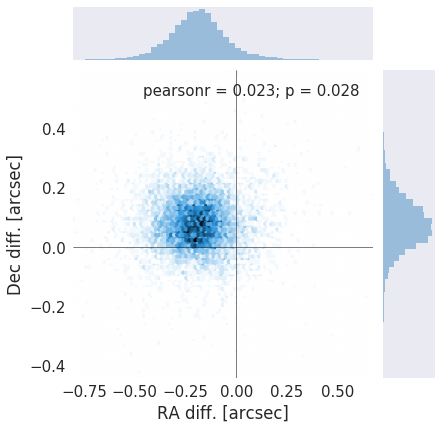

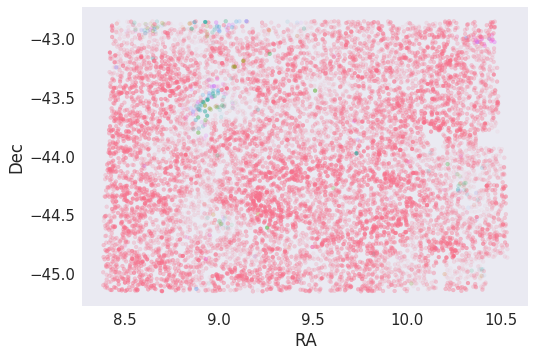

In [11]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [12]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.19172826693960587 arcsec
Dec correction: -0.07610839340514985 arcsec


In [13]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

/research/astro/fir/HELP/help_python/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


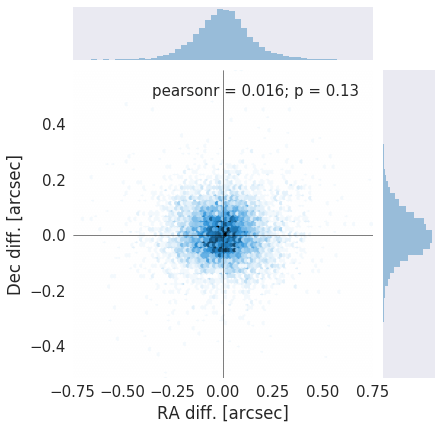

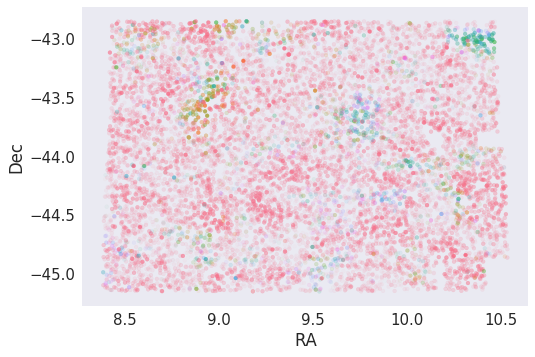

In [14]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [15]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [16]:
GAIA_FLAG_NAME = "video_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

9697 sources flagged.


## IV - Flagging objects near bright stars

In [17]:
#This section may be superseeded by merely using multiband detection as evidence of good data
#starmask.flag_artefacts

## V - Saving to disk

In [18]:
catalogue.write("{}/VISTA-VIDEO.fits".format(OUT_DIR), overwrite=True)